In [1]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.neighbors import KNeighborsRegressor
plt.rcParams["figure.figsize"] = (20,6)

### Criando funções

In [2]:
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [3]:
def apl_model (df_st,n_lags):

    print('Janela Analisada: ', n_lags,'dias\n')

    X = get_lags(df_st, n_lags)
    y = df_st.reindex(X.index)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.3)

    parameters = {'n_neighbors': range(1,50), 
            'weights': ['uniform','distance'], 
            'metric': ['euclidean','minkowski','manhattan']}

    knn = KNeighborsRegressor()
    knn_GS = GridSearchCV (knn, parameters, cv = TimeSeriesSplit(), error_score='raise')
    res = knn_GS.fit(X_train,y_train)

    print('#'*40)
    print('Melhor Score: ', res.best_score_)
    print('Melhores Parametros: ', res.best_params_)
    print('#'*40)

    print('Aplicando o Medelo Para os Melhores Parametros: \n\n\n')

    parameters = {'n_neighbors': [res.best_params_['n_neighbors']],
             'weights': [res.best_params_['weights']],
             'metric': [res.best_params_['metric']]}
    
    knn = KNeighborsRegressor()
    knn_GS = GridSearchCV (knn, parameters, cv = TimeSeriesSplit(), error_score='raise')
    res = knn_GS.fit(X_train,y_train)
    print( res.best_score_, res.best_params_)

    r2 = r2_score(knn_GS.predict(X_test),y_test)
    mse = mean_squared_error(knn_GS.predict(X_test),y_test)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(knn_GS.predict(X_test),y_test)
    mape = mean_absolute_percentage_error(knn_GS.predict(X_test),y_test)

    print('SVR model Results')
    print('r2' ,r2)
    print('mse' , mse)
    print('rmse', rmse)
    print('mae', mae)
    print('mape',  mape)

    #plot precisão com teste
    fig, ax = plt.subplots()
    ax.plot(knn_GS.predict(X_test).flatten(), label='pred')
    ax.plot(y_test.reset_index(drop=True), label='true')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show()

    #plot de total com previsão
    previsao = pd.DataFrame(knn_GS.predict(X_test).flatten(), index = X_test.index)
    concat = pd.concat([y_train, previsao],axis=1)

    concat.plot(linewidth=2,figsize=(20,7), color=['y','b'])
    plt.legend(['Real','Previsões'], fontsize=15)
    plt.xlabel('Período', size=15)
    plt.title('Previsões X Real',size=15)
    plt.show();

    fig, ax = plt.subplots()
    ax.plot(df_st, label='Real', color = 'y')
    ax.plot(previsao, label='Previsões', linewidth=2, color='b')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show();

    
    return r2, mse, rmse, mae, mape
    

In [4]:
def apl_for_lags (df_st):
    janelas = [ 7, 15, 30,45, 60]
    results = []

    for janela in janelas:
        r2, mse, rmse,mae, mape = apl_model (df_st, janela)
        result = [r2, mse, rmse,mae,mape]
        results.append(result)

    return results

### Lendo o dataset

In [5]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')

df_st = df['data_notificacao'].value_counts().rename_axis('Data_notificacao').to_frame('N_casos')
df_st.sort_index(inplace = True)
df_st

C:\Users\gabri\AppData\Local\Temp\ipykernel_6084\2810962173.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')


,N_casos
Data_notificacao,
2020-01-12,1
2020-01-20,3
2020-01-22,1
2020-01-24,1
2020-01-25,1
...,...
2022-06-17,1327
2022-06-18,550
2022-06-19,552


### Aplicando o modelo

Janela Analisada:  7 dias

########################################
Melhor Score:  0.37868023102247694
Melhores Parametros:  {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.37868023102247694 {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
SVR model Results
r2 -5.872605760711368
mse 1936476.3738722857
rmse 1391.5733447692528
mae 598.5397431675731
mape 0.5498343019692378


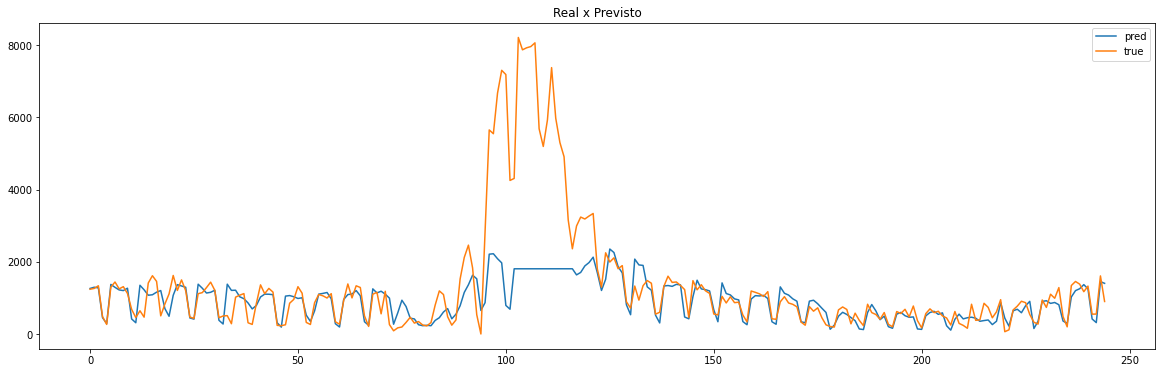

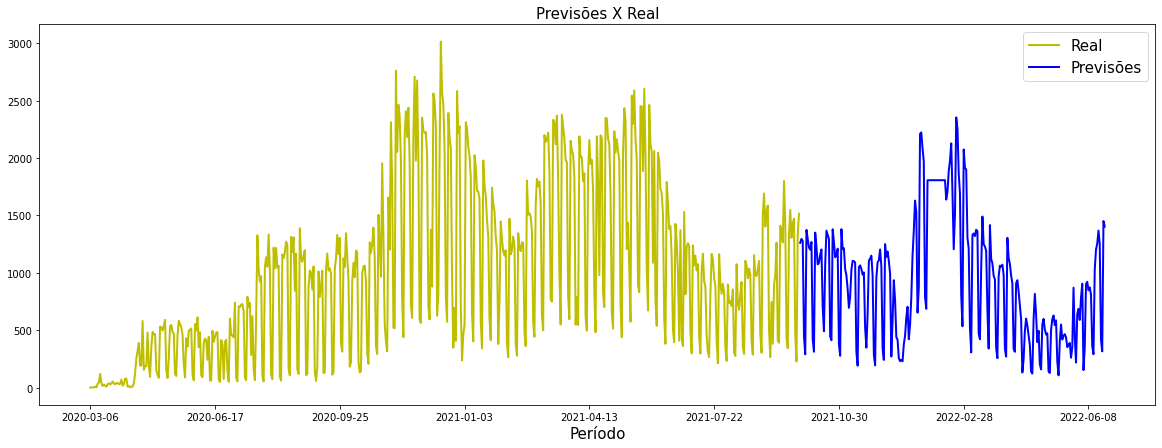

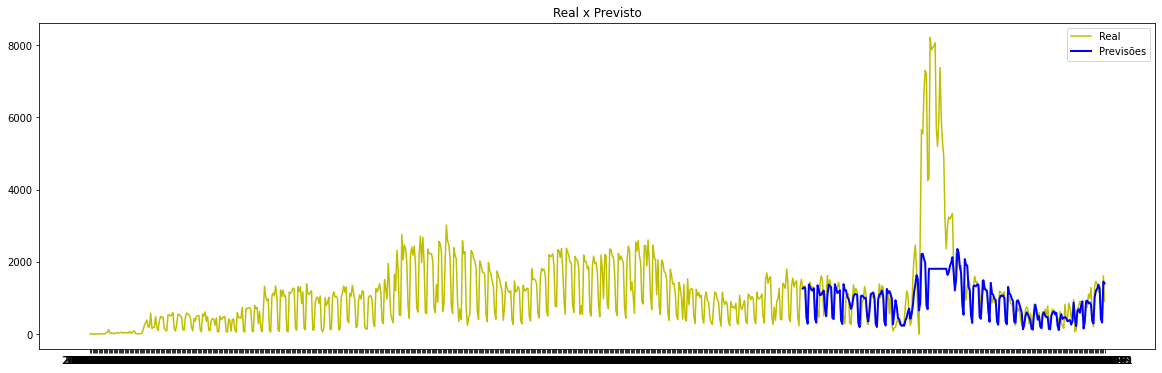

Janela Analisada:  15 dias

########################################
Melhor Score:  0.36559055380734806
Melhores Parametros:  {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.36559055380734806 {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
SVR model Results
r2 -6.9241858851432125
mse 2125559.9406622676
rmse 1457.9300191237808
mae 640.0489135874883
mape 0.6738546387859967


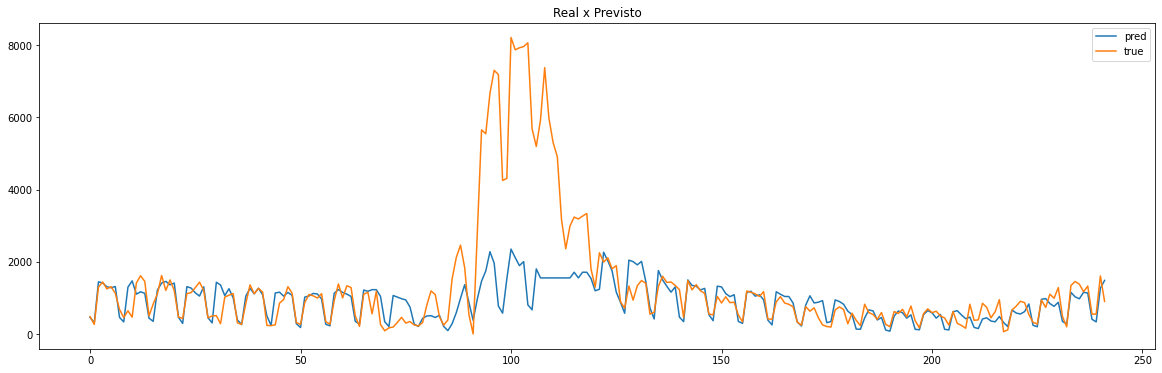

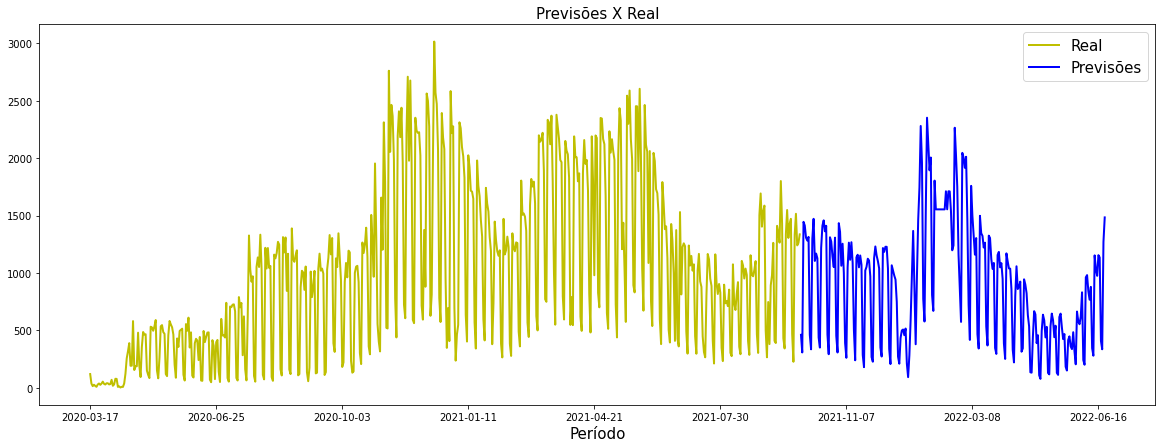

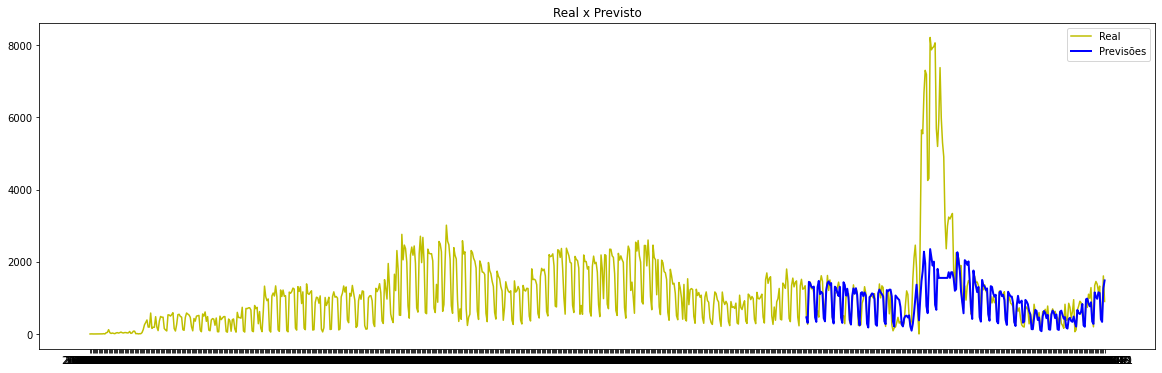

Janela Analisada:  30 dias

########################################
Melhor Score:  0.32761210653645356
Melhores Parametros:  {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.32761210653645356 {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
SVR model Results
r2 -6.053245355826212
mse 2053967.548952511
rmse 1433.16696478551
mae 647.2539733861572
mape 0.6912791820609343


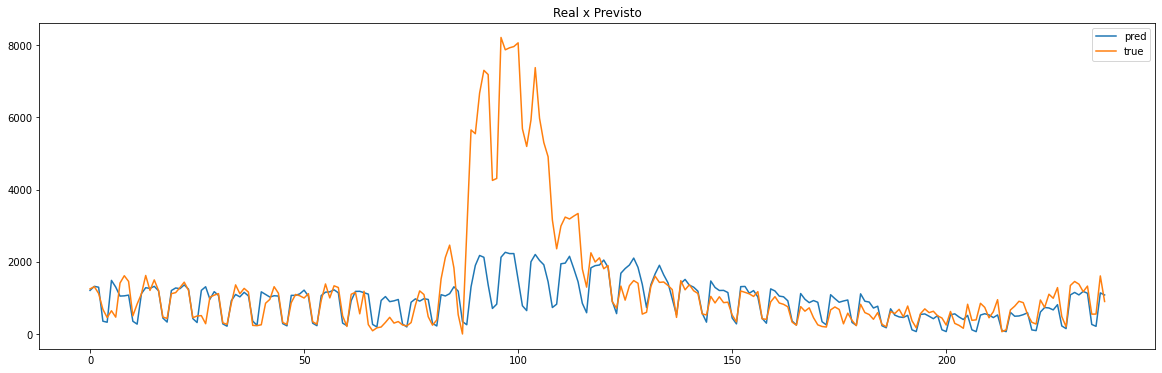

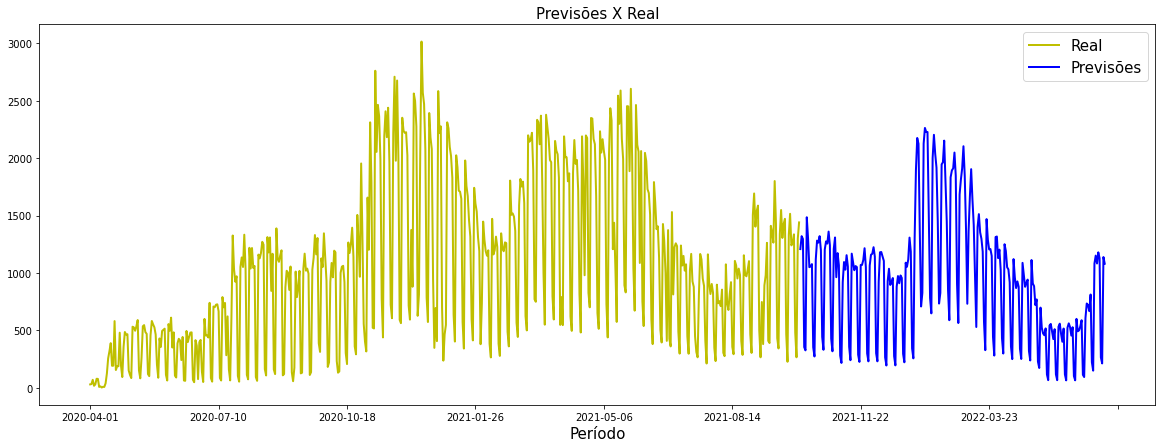

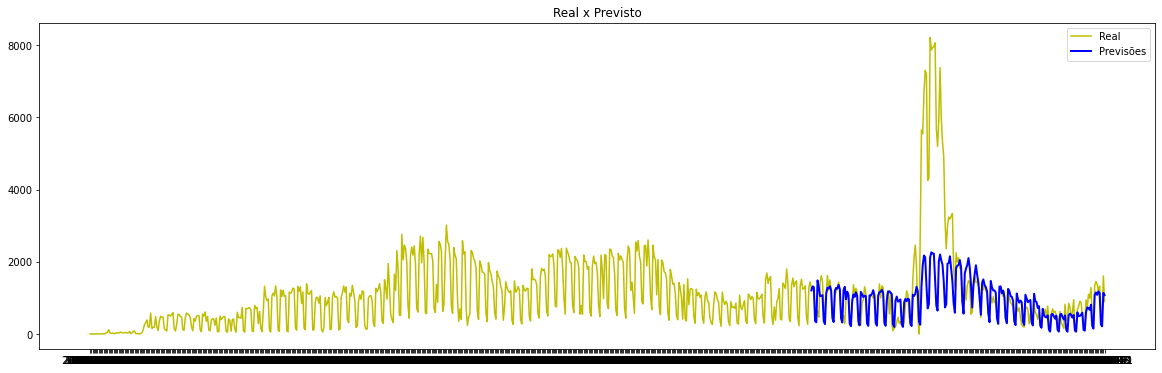

Janela Analisada:  45 dias

########################################
Melhor Score:  0.2709181788251547
Melhores Parametros:  {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.2709181788251547 {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
SVR model Results
r2 -7.02404902123244
mse 2189769.4285958027
rmse 1479.786953786187
mae 687.8331192479104
mape 0.7261168544724913


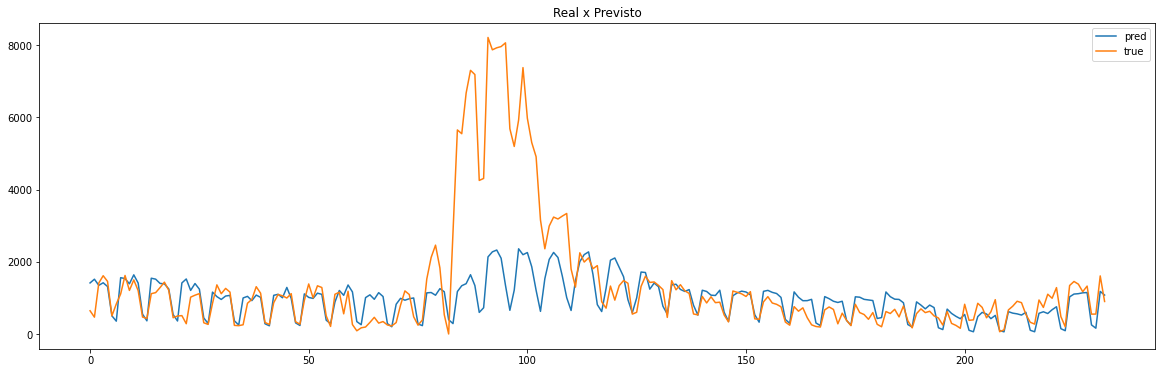

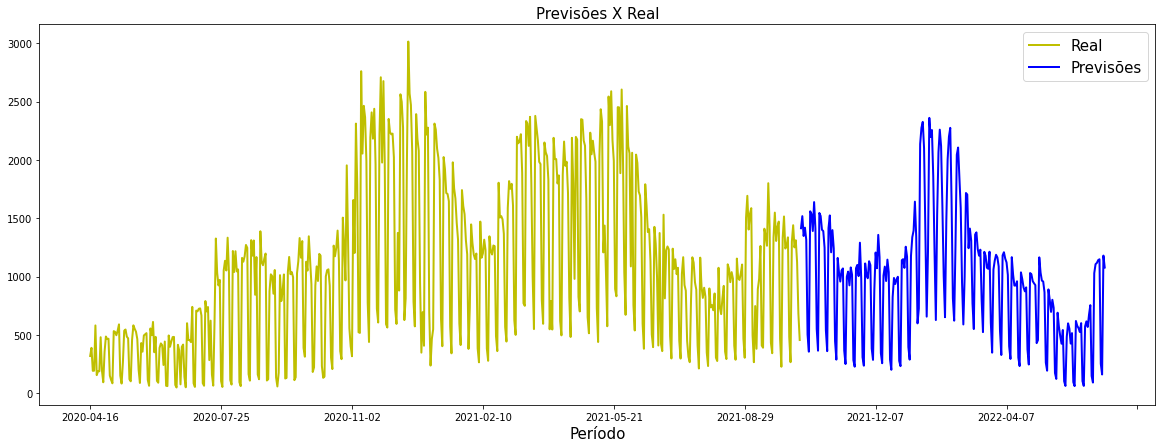

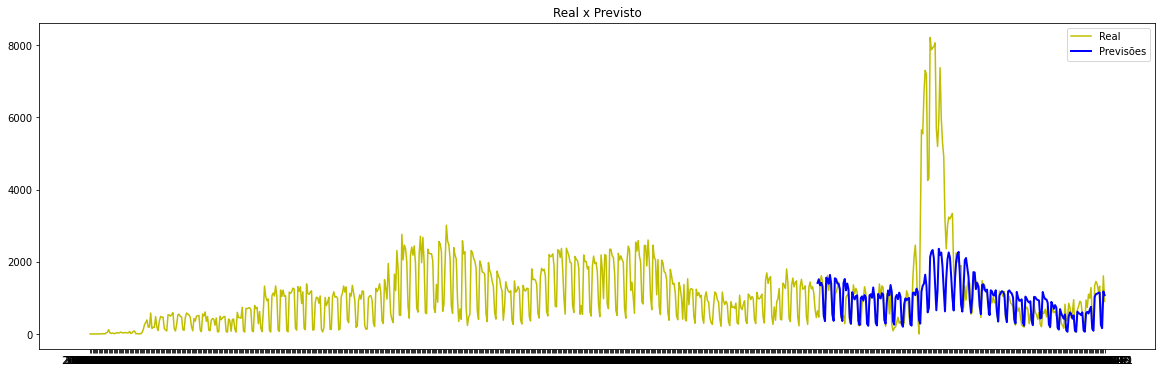

Janela Analisada:  60 dias

########################################
Melhor Score:  0.3929758685774615
Melhores Parametros:  {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.3929758685774615 {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
SVR model Results
r2 -6.534928484846934
mse 2207865.379096426
rmse 1485.8887505787322
mae 691.1452285394963
mape 0.7243888225485643


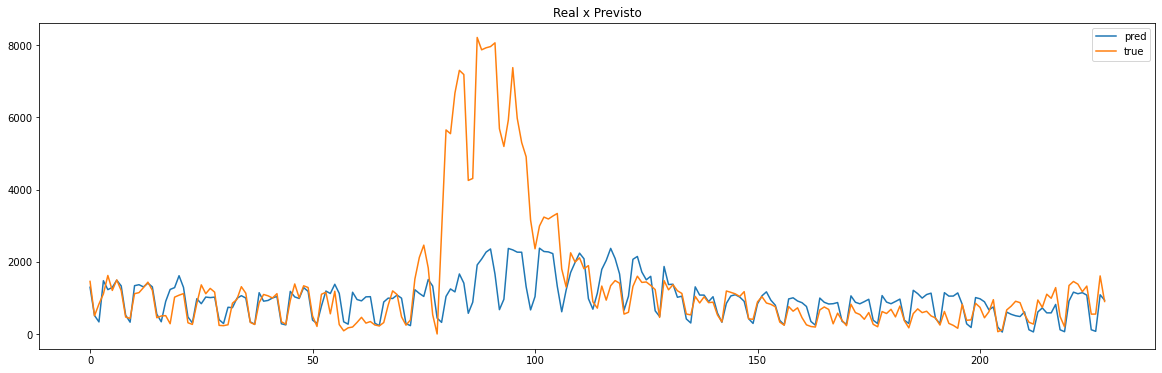

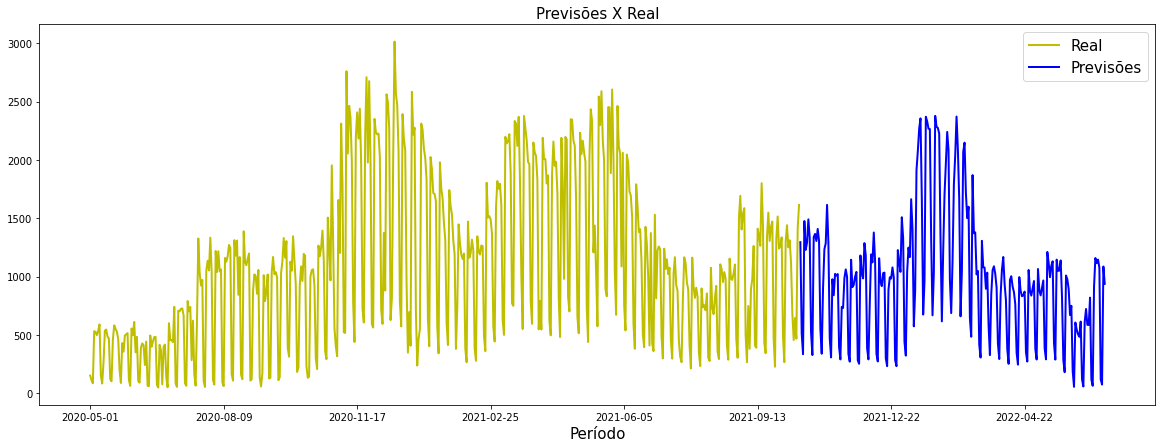

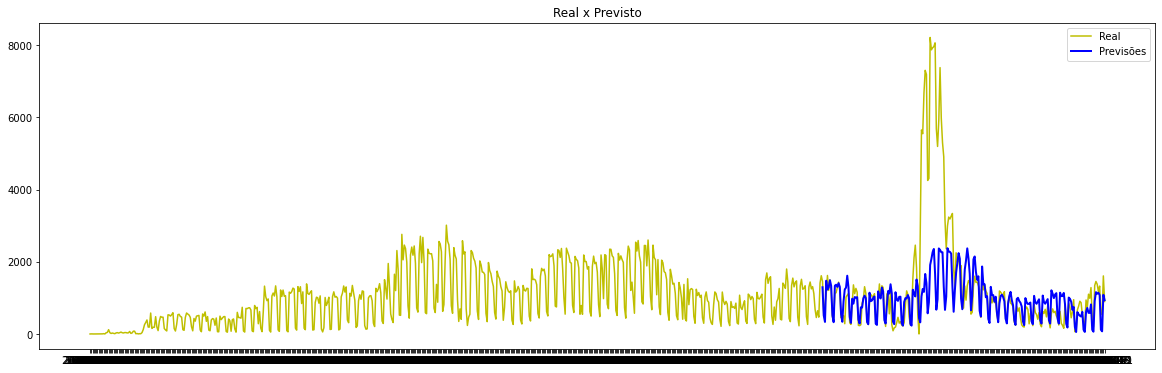

In [6]:
results = apl_for_lags (df_st)

### Resultados

In [7]:
df_results = pd.DataFrame(results, columns=('R2', 'MSE', 'RMSE','MAE','MAPE' ), index=('7 dias', '15 dias', '30 dias', '45 dias', '60 dias'))
df_results.sort_values(by='R2' , ascending = False)

,R2,MSE,RMSE,MAE,MAPE
7 dias,-5.872606,1.936476e+06,1391.573345,598.539743,0.549834
30 dias,-6.053245,2.053968e+06,1433.166965,647.253973,0.691279
60 dias,-6.534928,2.207865e+06,1485.888751,691.145229,0.724389
15 dias,-6.924186,2.125560e+06,1457.930019,640.048914,0.673855
45 dias,-7.024049,2.189769e+06,1479.786954,687.833119,0.726117
